<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

<b><font size=5>Отток клиентов</font></b><a name="0."></a>

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<b><font size=5>Описание данных</font></b><a name="1."></a>


<b>Признаки</b>
 * RowNumber — индекс строки в данных
 * CustomerId — уникальный идентификатор клиента
 * Surname — фамилия
 * CreditScore — кредитный рейтинг
 * Geography — страна проживания
 * Gender — пол
 * Age — возраст
 * Tenure — сколько лет человек является клиентом банка
 * Balance — баланс на счёте
 * NumOfProducts — количество продуктов банка, используемых клиентом 
 * HasCrCard — наличие кредитной карты (1 - есть, 0 - нет)
 * IsActiveMember — активность клиента (1 - активный, 0 - нет)
 * EstimatedSalary — предполагаемая зарплата
 
 
<b>Целевой признак</b>
* Exited — факт ухода клиента  

<b><font size=5>Задачи</font></b><a name="2."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

<b>Перед нами стоит задача классификации, а значит нам надо:</b>

1. Подготовить и исследовать данные, включая баланс классов
* Обучить разные модели и найти лучшую. 
* Провести финальное тестирование.
* Общий вывод

<b><font size=5>Подготовка и исследование данных</font></b><a name="3."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Загрузим и ознакомимся с нашими данными

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from tqdm.auto import tqdm

import category_encoders as ce

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from scipy.stats import norm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef, classification_report,roc_curve, roc_curve, auc


In [2]:
def get_bootstrap(
        data_column_1, 
        data_column_2, 
        boot_it=1000,  
        statistic=np.mean, 
        bootstrap_conf_level=0.95,  
        alpha=0.05
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True
        ).values

        samples_2 = data_column_2.sample(
            boot_len,  
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else: 
        print("Не получилось отвергнуть нулевую гипотезу")
    return {"quants": quants,
            "p_value": p_value}

In [3]:
df = pd.read_csv('***')

In [4]:
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9607,9608,15806918,Ireland,674,France,Male,28,5.0,0.00,1,1,1,151925.25,0
6635,6636,15678374,Colombo,666,France,Female,59,5.0,0.00,2,1,1,185123.09,0
8510,8511,15769353,Jenkins,550,France,Female,40,8.0,150490.32,1,0,0,166468.21,1
1460,1461,15657085,Gardiner,578,France,Male,23,10.0,88980.32,1,1,1,125222.36,0
4228,4229,15691061,Rapuokwu,740,France,Female,37,9.0,0.00,2,1,1,73225.31,0
3349,3350,15603465,Dunn,665,Germany,Female,45,5.0,155447.65,2,1,0,51871.95,1
2108,2109,15634949,Hay,593,Germany,Male,74,5.0,161434.36,2,1,1,65532.17,0
633,634,15724282,Tsao,540,Germany,Male,44,3.0,164113.04,2,1,1,12120.79,0
5408,5409,15638257,P'an,682,Spain,Female,54,0.0,83102.72,2,1,1,54132.93,0
6414,6415,15642912,Tu,618,France,Female,21,NaN,125682.79,1,0,0,57762.00,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
df.duplicated().sum()

0

In [8]:
df.Tenure.isnull().sum()

909

In [9]:
df[df['Tenure'].isnull() == True].sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3413,3414,15627412,Ferri,605,France,Male,39,NaN,0.00,2,1,0,199390.45,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
8048,8049,15595713,Heller,548,Spain,Male,33,NaN,0.00,1,1,1,31728.35,0
3436,3437,15735632,Williamson,571,France,Male,41,NaN,0.00,1,1,1,63736.17,0
1667,1668,15718247,Hayden,606,Spain,Female,46,NaN,0.00,2,1,1,183717.94,0
3960,3961,15616811,MacDonald,535,France,Male,47,NaN,160729.10,1,0,1,145986.35,0
3608,3609,15601873,Bull,677,France,Female,36,NaN,0.00,1,1,0,47318.75,0
6762,6763,15631457,Asher,639,France,Male,37,NaN,98186.70,1,0,1,173386.95,0
3471,3472,15743582,T'ang,632,France,Female,27,NaN,107375.82,1,1,1,62703.38,0
2283,2284,15624633,Kibby,702,France,Male,45,NaN,74989.58,1,1,1,171014.69,0


In [10]:
df.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

(-1.25, 1.25, -1.25, 1.25)

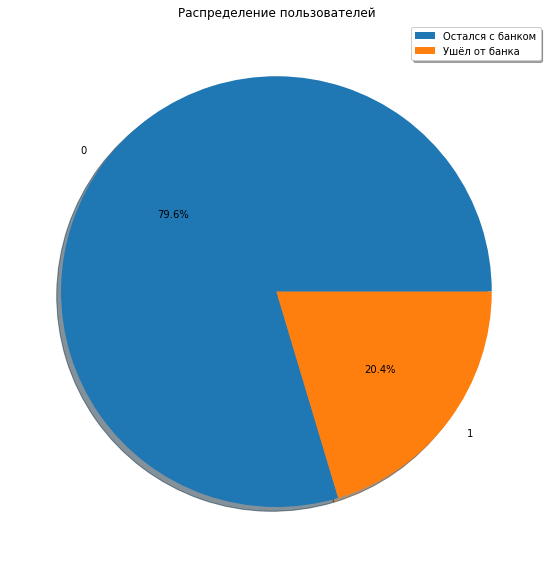

In [11]:
df.Exited.value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, figsize=(10,8))
plt.legend(["Остался с банком", 'Ушёл от банка'], fontsize=10, shadow=True, facecolor='w')
plt.title('Распределение пользователей')
plt.tight_layout()
plt.axis('off')

<b><font size=4>Первые выводы</font></b><a name="3.1."></a>
[<font size="2">(к содержанию)</font>](#to_content.)


Итак, пройдя этап знакомства с данными можно сделать вывод, что:

1. В выборке представлены клиенты, где у 79.6% - остались с банком, а 20.4% ушли от банка, что говорит нам о том, что данные довольно несбалансированы.
2. Пропущенные значения лежат в столбце Tenure, который говорит о том, сколько времени является клиент. Соответственно данный показатель слишком индивидуальный, а так же, вероятно, имеет вес в нашем дальнейшем обучении моделей, поэтому будет принято решение о том, что данный показатель мы уберём. С точки зрения скорости это самый приемлимый вариант. Обучать модель на предсказание значений у нас нет, а заполнять медианой, модой или средним не самая лучшая идея. 
3. Так же обратим внимание, что клиентами банка являются жители стран Франции (50% в выборке), Германии (25%) и Испании (25%).
4. Признаки в столбцах RowNumber,CustomerId	и Surname не несут никакой информации для наших будущих моделей, скорее наоборот. Так что избавимся от них в дальнейшем.
5. Так же заметим, что клиенты банка могут иметь всего 4 продукта от этого банка.
6. Так же в столбце CreditScore распределены люди с разным уровнем кредитного рейтинга, но в среднем имеют хорошую оценку. С Распределениями оценок можно ознакомиться ниже.
![Image of Yaktocat](https://progresscard.ru/images/credit_raiting.jpg)

<b> С данными познакомились, теперь посмотрим на признаки поближе и уберём лишние</b>

<b><font size=4>Исследовательский анализ</font></b><a name="3.2."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Для начала посмотрим в какой стране чаще уходят. Для этого посмотрим на доли ушедших и оставшихся пользователей в каждой стране. 

In [12]:
def check_ratio(What_check):
    a = df.groupby([What_check, 'Exited'])['RowNumber'].count().rename("ratio")
    b = a /  a.groupby(level=0).sum() 
    dfs = pd.DataFrame(data=b)
    return dfs.style.bar()

In [13]:
check_ratio('Geography')

Ага, видим, что во Франции и Испании дела обстоят примерно одинаково, а вот в Германии % ушедших выше, чем в других странах практически в 2 раза. Либо это закономерность, либо случайность. В общем, на это стоит обратить внимание. Так же это нам говорит о том, что это достаточно важный признак.

In [14]:
check_ratio('Gender')

Так же заметим, что девушки уходят чаще, чем мужчины. Опять же, это либо закономерность, либо случайность. 

Теперь посмотрим на распределение возраста среди наших групп.

Text(0, 0.5, 'Колличество клиентов')

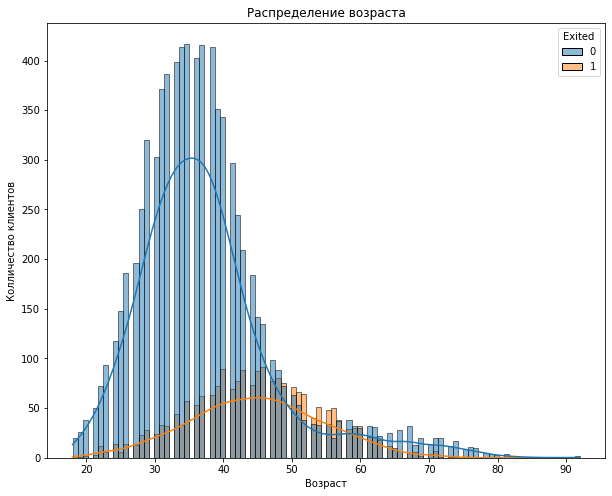

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='Age',hue='Exited', kde=True,bins=100, ax=ax)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Колличество клиентов')

Text(0, 0.5, 'Ушёл клиент или нет')

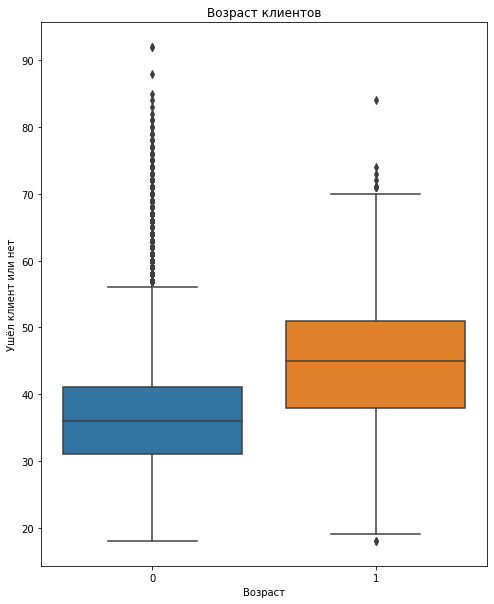

In [16]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Exited',y='Age')
plt.title('Возраст клиентов')
plt.xlabel('Возраст')
plt.ylabel('Ушёл клиент или нет')

По данным графиках видно, что люди, которые уходят более старшего возраста, чем те, которые остаются. Учитывая, что наша выборка имеет дисбаланс, то разделим наши выборки и сравним средние бутстрап методом. 

Итак, нулевая гипотеза гласит нам о том, что средний возраст в наших группах одинаковый, а альтернативная гипотеза о том, что возраст отличается.

In [17]:
leave = df[df['Exited'] == 1]
did_not_leave = df[df['Exited'] == 0]

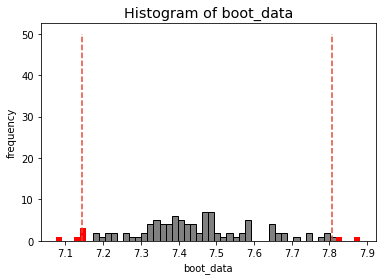

Отвергаем нулевую гипотезу


{'quants':               0
 0.025  7.143137
 0.975  7.805350,
 'p_value': 0.0}

In [18]:
get_bootstrap(leave.Age, did_not_leave.Age, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Итак, если переводить на человеческий язык, то можно сказать, что люди, которые уходят более старшего возраста, чем те, которые остаются. Теперь посмотрим на другие признаки и так же прогоним их через бутсрап метод. Возьмём за основу, что нулевая гипотеза всегда нам говорит о равенстве, а альтернативная о различии.

Text(0, 0.5, 'Колличество клиентов')

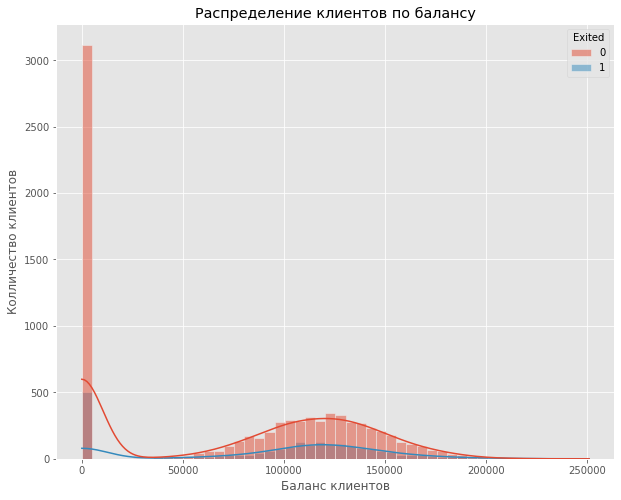

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='Balance',hue='Exited', kde=True,bins=50, ax=ax)
plt.title('Распределение клиентов по балансу')
plt.xlabel('Баланс клиентов')
plt.ylabel('Колличество клиентов')

Text(0, 0.5, 'Колличество клиентов')

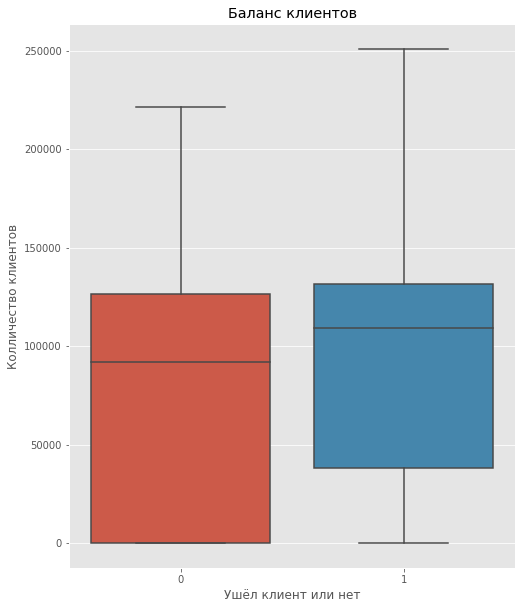

In [20]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=df, x='Exited',y='Balance')
plt.title('Баланс клиентов')
plt.xlabel('Ушёл клиент или нет')
plt.ylabel('Колличество клиентов')

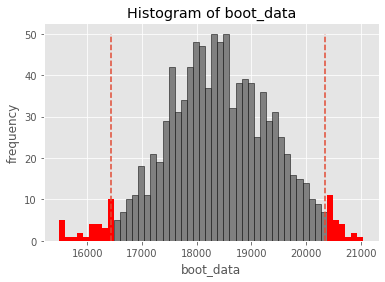

Отвергаем нулевую гипотезу


{'quants':                   0
 0.025  16436.834990
 0.975  20349.877789,
 'p_value': 2.707923291736891e-78}

In [21]:
get_bootstrap(leave.Balance, 
              did_not_leave.Balance, boot_it = 1000,
              statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Тут видно, что баланс всё-таки имеет значение. Что те, кто уходит имеют баланс счёта выше, чем те, кто остаётся. Теперь посмотрим как обстоят дела с зарплатой.

Text(0, 0.5, 'Колличество клиентов')

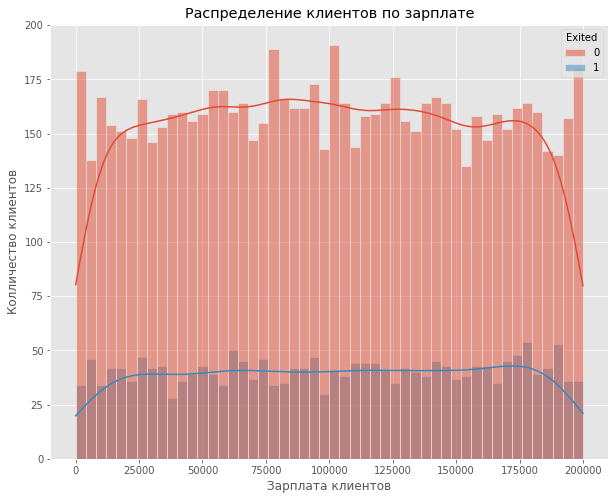

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='EstimatedSalary',hue='Exited', kde=True,bins=50, ax=ax)
plt.title('Распределение клиентов по зарплате')
plt.xlabel('Зарплата клиентов')
plt.ylabel('Колличество клиентов')

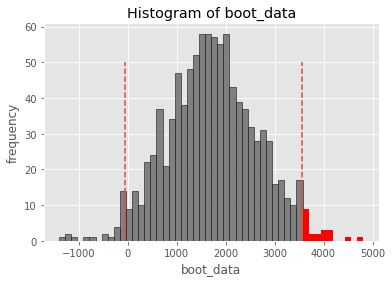

Не получилось отвергнуть нулевую гипотезу


{'quants':                  0
 0.025   -50.719748
 0.975  3552.658211,
 'p_value': 0.060100164871156124}

In [23]:
get_bootstrap(leave.EstimatedSalary, 
              did_not_leave.EstimatedSalary, boot_it = 1000,
              statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

А вот зарплата не имеет значения. 

Text(0, 0.5, 'Колличество клиентов')

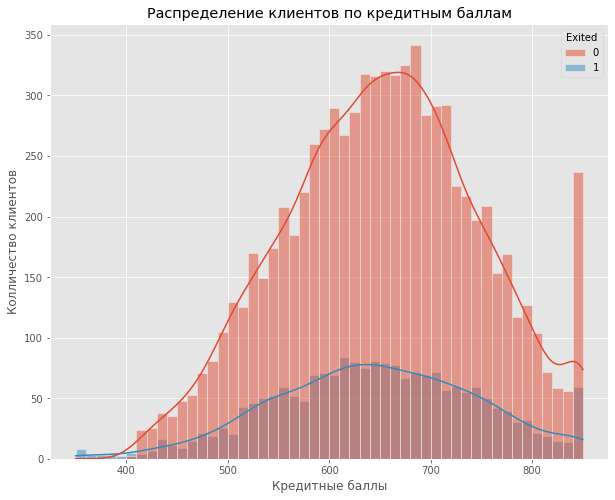

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='CreditScore',hue='Exited', kde=True,bins=50, ax=ax)
plt.title('Распределение клиентов по кредитным баллам')
plt.xlabel('Кредитные баллы')
plt.ylabel('Колличество клиентов')

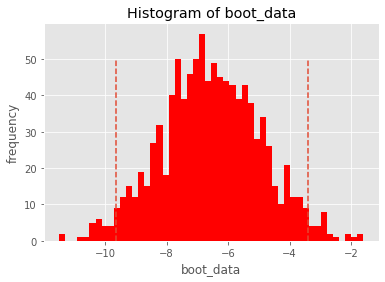

Отвергаем нулевую гипотезу


{'quants':               0
 0.025 -9.635643
 0.975 -3.407055,
 'p_value': 4.4224161559480104e-05}

In [25]:
get_bootstrap(leave.CreditScore,
              did_not_leave.CreditScore, boot_it = 1000,
              statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Ага, тут можно сказать, что те, кто уходит имеют более низкий кредитный рейтинг, чем те, кто остался с банком. Теперь глянем на колличество продуктов. 

([<matplotlib.axis.XTick at 0x2d96f1d42b0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

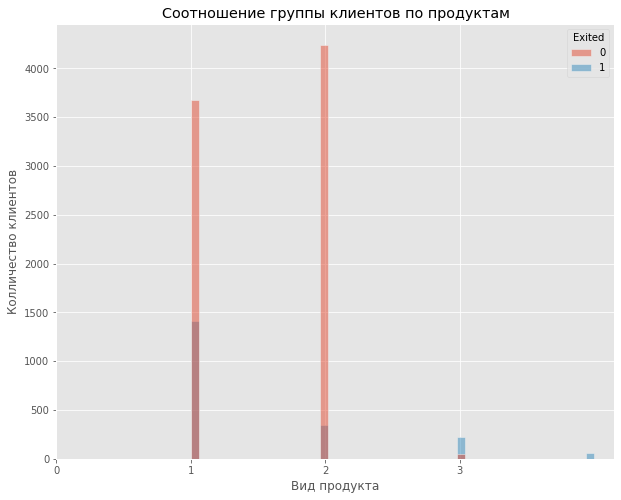

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='NumOfProducts',hue='Exited', kde=False,bins=50, ax=ax)
plt.title('Соотношение группы клиентов по продуктам')
plt.xlabel('Вид продукта')
plt.ylabel('Колличество клиентов')
plt.xticks(np.arange(0,4,1))

In [27]:
check_ratio('NumOfProducts')

Ознакомившись с таблицами можно предположить, что люди имеющих 2 продукта более надежны, чем те у кого их 1 или 3 или 4.

([<matplotlib.axis.XTick at 0x2d96f7498e0>], [Text(0, 0, '')])

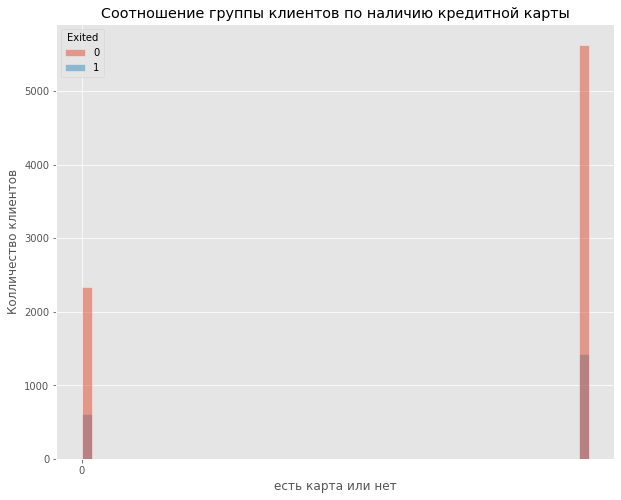

In [28]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='HasCrCard',hue='Exited', kde=False,bins=50, ax=ax)
plt.title('Соотношение группы клиентов по наличию кредитной карты')
plt.xlabel('есть карта или нет')
plt.ylabel('Колличество клиентов')
plt.xticks(np.arange(0,1,1))

In [29]:
check_ratio('HasCrCard')

Наличие кредитной карты особо не влияет на то, что ушёл клиент или нет. Теперь посмотрим на то, что влияет ли как-то активность клиента или нет

([<matplotlib.axis.XTick at 0x2d96f6b31f0>], [Text(0, 0, '')])

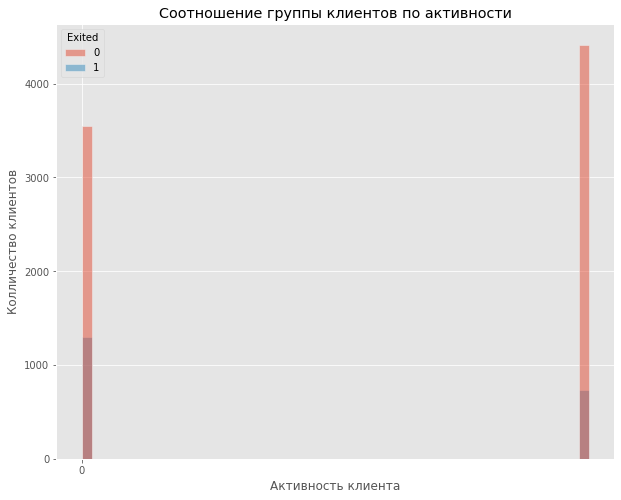

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='IsActiveMember',hue='Exited', kde=False,bins=50, ax=ax)
plt.title('Соотношение группы клиентов по активности')
plt.xlabel('Активность клиента')
plt.ylabel('Колличество клиентов')
plt.xticks(np.arange(0,1,1))

In [31]:
check_ratio('IsActiveMember')

Тут можно увидеть, что чаще уходят менее активные пользователи, чем активные. Но учитывая, опять же баланс классов сложно сказать точно. Теперь посмотрим влияет ли колличество лет на то, что уйдёт клиент или нет.

Text(0, 0.5, 'Колличество людей')

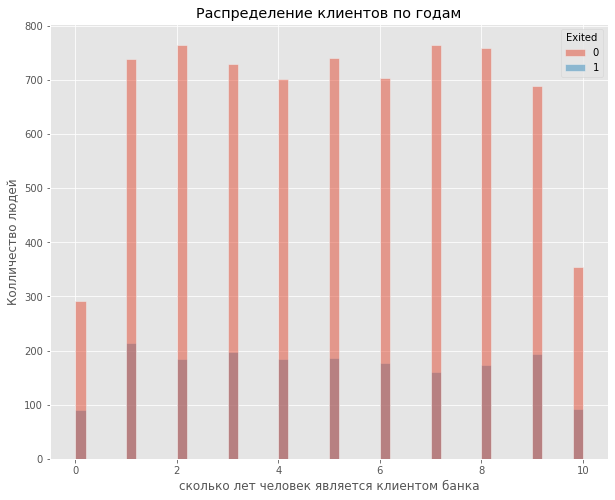

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.histplot(data=df, x='Tenure',hue='Exited',bins=50, ax=ax)
plt.title('Распределение клиентов по годам')
plt.xlabel('сколько лет человек является клиентом банка')
plt.ylabel('Колличество людей')

In [33]:
check_ratio('Tenure')

% ухода практически везде одинаков. О чём это говорит? О том, что уйти могут как и те клиенты, которые были с банком 10 лет, так и те, кто пробыл с банком меньше года. Так же стоит помнить, что в данном столбце пропущенны значения, что плохо для нашей модели. Так что данный признак можно будет убрать, так же как и признак о зарпллате клиента. 

In [34]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

Text(0.5, 1.0, 'Корреляция между признаками')

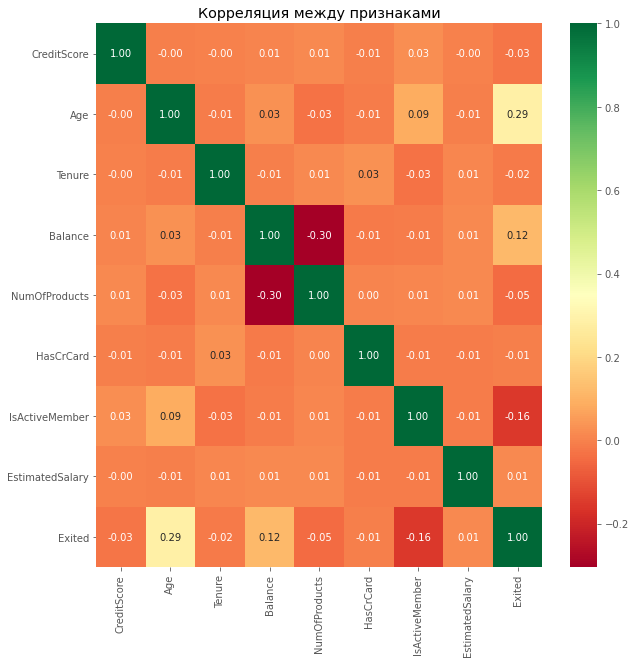

In [35]:
Corr=df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(Corr, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками')

Итак, тут видим, что с Exited есть небольшая положительная корреляция у таких признаков как возраст и баланс. Что показывает нам, что чем старше человек, тем больше Exited, а точнее 1. Так же и с балансом. С активностью можем наблюдать небольшую отрицательную корреляцию, т.е. если человек не активен, то уйдет. Вполне логично.
Так же видим, отрицательную корреляцию между балансом и колличеством продуктов. Чем больше у человека продуктов банка, тем ниже его баланс. 

<b><font size=4>Выводы после анализа</font></b><a name="3.3"></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Итак, пройдясь по нашим признакам можно прикинуть примерный портрет пользователей, которые уходят. Посмотрим на признаки, которые говорят нам об этом.

1. клиенты с Германии
2. женского пола
3. имеют невысокий кредитный рейтинг
4. Не особо активны
5. Люди более зрелого возраста
6. Имеют небольшой баланс


<b><font size=4>Кодировка данных</font></b><a name="3.4."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Теперь подготовим наши данные к обучению модели. Для начала уберём лишние признаки. После исследовательского анализа можно сказать, что уход клиента не связан с тем, сколько пробыл данный человек с банком. Равновероятно, что человек уйдёт как сразу, так и после 10 лет обслуживания в банке. Уберём и наличие кредитной карты. Я думаю, что этот признак уже указан в колличестве продуктов у данного пользователя. Так же мы выяснили, что в среднем зарплата клиента не влияет на то, что уйдёт человек или нет. А точнее, что средние в группах равны.

In [36]:
new_df = df.drop(columns=['Tenure', 'EstimatedSalary','HasCrCard'])

Теперь разделим наши данные на признаки и целевой признак и перекодируем их. Приведём признак кредитного рейтинга в ординальную переменную и закодируем её. Остальные признаки номинативные, так что здесь хорошо зайдёт OHE кодировка. Т.к. мы в дальнейшем будем использовать модели деревьев, то колличественные переменные кодировать не будем.

In [37]:
bins = [0,500,600,650,690, 850]
labels = [1,2,3,4,5]
new_df['CreditScore_cats'] = pd.cut(new_df['CreditScore'], bins=bins, labels=labels)

In [38]:
new_df = new_df.drop(columns=['CreditScore'])

Теперь разделим нашу выборки на тестовую и обучающую. 

In [39]:
features_train, features_test, target_train, target_test = train_test_split(
    new_df.drop(['Exited'], axis=1), new_df['Exited'], test_size=0.25, random_state=42, stratify=new_df['Exited'])

Перекодируем наши признаки.

In [40]:
ce_one_hot = ce.OneHotEncoder(cols=['Geography', 'Gender'])
features_train = ce_one_hot.fit_transform(features_train, target_train)
features_test = ce_one_hot.transform(features_test, target_test)

In [41]:
ce_ord = ce.OrdinalEncoder(cols = ['NumOfProducts', 'CreditScore_cats'])
features_train = ce_ord.fit_transform(features_train, target_train)
features_test = ce_ord.transform(features_test, target_test)

Уравновесим наш баланс в выборке оверсэмплингом. Для этого будем использовать алгоритм SMOTE, основанный на идее генерации некоторого количества искусственных примеров, которые были бы «похожи» на имеющиеся в миноритарном классе, но при этом не дублировали их.

In [42]:
features_oversampled, target_oversampled = SMOTE(random_state=0).fit_resample(features_train, target_train)
features_oversampled.sample(5)

,Geography_1,Geography_2,Geography_3,Gender_1,Gender_2,Age,Balance,NumOfProducts,IsActiveMember,CreditScore_cats
9570,0,1,0,0,0,38,117304.14275,2,0,5
4985,1,0,0,0,1,52,0.00000,2,1,2
1389,1,0,0,1,0,42,0.00000,1,0,4
10010,1,0,0,1,0,44,0.00000,2,1,3
5923,1,0,0,1,0,20,133800.98000,2,1,5


In [43]:
target_oversampled.value_counts(normalize=True)

1    0.5
0    0.5
Name: Exited, dtype: float64

Теперь путем случайного отбора уравновесим нашу выборку андерсэмплингом.

In [44]:
rus = RandomUnderSampler()
features_undersampled, target_undersampled = rus.fit_resample(features_train, target_train)
features_undersampled.sample(5)

,Geography_1,Geography_2,Geography_3,Gender_1,Gender_2,Age,Balance,NumOfProducts,IsActiveMember,CreditScore_cats
2497,1,0,0,0,1,32,0.00,1,0,5
2748,0,1,0,0,1,40,107949.45,2,0,3
3054,0,0,1,0,1,42,41473.33,2,0,4
2254,1,0,0,1,0,54,0.00,2,0,4
231,1,0,0,1,0,39,112687.69,2,1,2


In [45]:
target_undersampled.value_counts(normalize=True)

1    0.5
0    0.5
Name: Exited, dtype: float64

<b><font size=4>Обший вывод по данному шагу</font></b><a name="3.5."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

В данном шаге мы провели стат.анализ. Посмотрели на более выраженые признаки. Лишние отбросили. Так же закодировали наши переменные под обучение моделей с деревьями. Так же уравновесили наши выборки двумя разными методами. 

<b><font size=5>Обучение модели</font></b><a name="4."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Теперь приступим к обучению модели и посмотрим какая из них поведёт себя лучше и на каких выборках. Оценивать будем по F1 оценке.

In [46]:
clf_rfc = RandomForestClassifier()
parametrs_rfc = {'n_estimators': range (10, 61, 10), 'max_depth': range (1,15)}
grid_rfc = GridSearchCV(clf_rfc, parametrs_rfc, cv=5, n_jobs=-1, scoring='f1')
grid_rfc.fit(features_train, target_train)
print('F1 лучшей модели', grid_rfc.best_score_, 'с параметрами', grid_rfc.best_params_ )

F1 лучшей модели 0.5736837375252237 с параметрами {'max_depth': 12, 'n_estimators': 40}


In [47]:
clf_rfc_ov = RandomForestClassifier()
parametrs_rfc_ov = {'n_estimators': range (10, 91, 10), 'max_depth': range (1,25)}
grid_rfc_ov = GridSearchCV(clf_rfc_ov, parametrs_rfc_ov, cv=5, n_jobs=-1, scoring='f1')
grid_rfc_ov.fit(features_oversampled, target_oversampled)
print('F1-оценка лучшей модели', grid_rfc_ov.best_score_, 'с параметрами', grid_rfc_ov.best_params_ )

F1-оценка лучшей модели 0.8596480921149384 с параметрами {'max_depth': 14, 'n_estimators': 80}


In [48]:
clf_rfc_und = RandomForestClassifier()
parametrs_rfc_und = {'n_estimators': range (10, 91, 10), 'max_depth': range (1,20)}
grid_rfc_und = GridSearchCV(clf_rfc_und, parametrs_rfc_und, cv=5, n_jobs=-1, scoring='f1')
grid_rfc_und.fit(features_undersampled, target_undersampled)
print('F1-оценка лучшей модели', grid_rfc_und.best_score_, 'с параметрами', grid_rfc_und.best_params_ )

F1-оценка лучшей модели 0.7840947892988843 с параметрами {'max_depth': 8, 'n_estimators': 70}


In [49]:
clf_dtc = DecisionTreeClassifier()
parametrs_dtc = {'max_depth': range (1,31)}
grid_dtc = GridSearchCV(clf_dtc, parametrs_dtc, cv=5, n_jobs=-1, scoring='f1')
grid_dtc.fit(features_train, target_train)
print('F1-оценка лучшей модели', grid_dtc.best_score_, 'с параметрами', grid_dtc.best_params_ )

F1-оценка лучшей модели 0.5444375397376746 с параметрами {'max_depth': 9}


In [50]:
clf_dtc_ov = DecisionTreeClassifier()
parametrs_dtc_ov = {'max_depth': range (1,31)}
grid_dtc_ov = GridSearchCV(clf_dtc_ov, parametrs_dtc_ov, cv=5, n_jobs=-1, scoring='f1')
grid_dtc_ov.fit(features_oversampled, target_oversampled)
print('F1-оценка лучшей модели', grid_dtc_ov.best_score_, 'с параметрами', grid_dtc_ov.best_params_ )

F1-оценка лучшей модели 0.8327300121924331 с параметрами {'max_depth': 13}


In [51]:
clf_dtc_und = DecisionTreeClassifier()
parametrs_dtc_und = {'max_depth': range (1,31)}
grid_dtc_und = GridSearchCV(clf_dtc_und, parametrs_dtc_und, cv=5, n_jobs=-1, scoring='f1')
grid_dtc_und.fit(features_undersampled, target_undersampled)
print('F1-оценка лучшей модели', grid_dtc_und.best_score_, 'с параметрами', grid_dtc_und.best_params_ )

F1-оценка лучшей модели 0.7643756119135033 с параметрами {'max_depth': 6}


In [52]:
best_model = grid_rfc_ov.best_estimator_

<b><font size=4>Вывод по данному шагу</font></b><a name="4.1"></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Наилучшую оценку нам показала модель случайного леса с оверсемплингом. Приведём тестирование и посмотрим на результаты.

<b><font size=5>Тестирование модели</font></b><a name="5."></a>
[<font size="2">(к содержанию)</font>](#to_content.)

In [53]:
def draw_ROC(target, features, model):
    fpr, tpr, thresholds = roc_curve(target, model.predict_proba(features)[:,1], pos_label=1)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show() 

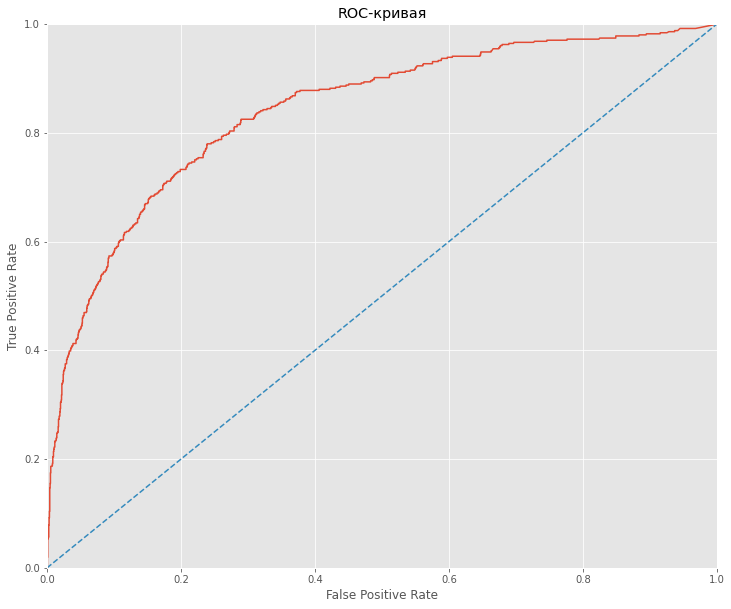

In [54]:
draw_ROC(target_test, features_test, best_model)

In [55]:
predicted_test = best_model.predict(features_test)
f1_score(target_test, predicted_test)

0.5935114503816793

In [56]:
print(classification_report(target_test,predicted_test))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1991
           1       0.58      0.61      0.59       509

    accuracy                           0.83      2500
   macro avg       0.74      0.75      0.74      2500
weighted avg       0.83      0.83      0.83      2500



Text(0.5, 1.05, 'Confusion_matrix')

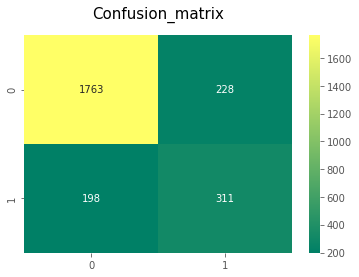

In [57]:
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

<b><font size=4>Вывод по данному шагу</font></b><a name="5.1"></a>
[<font size="2">(к содержанию)</font>](#to_content.)

Итак, f1 оценка на тестовой модели показала нам 0.60. Roc-кривая показала нам неплохие результаты, которые говорят, что модель предсказывала не случайно и чаще отвечала верно.